In [18]:
import tensorflow as tf
import numpy as np
from scipy.ndimage import zoom
import torch

# Load TensorFlow MNIST data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize and reshape
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

### Load Model

In [17]:
folder = "../model/"
model_tf = tf.keras.models.load_model(folder + 'model_tf')
#model_tf = tf.keras.models.load_model(folder + 'model_tf.h5')

In [21]:
# Evaluate the model
test_loss, test_acc = model_tf.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.0444 - accuracy: 0.9863 - 232ms/epoch - 743us/step

Test accuracy: 0.986299991607666


In [26]:
import tensorflow_model_optimization as tfmot

# Apply quantization to the layers
quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model_tf)

# 'quantize_model' requires a recompile
q_aware_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

q_aware_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (Quantize  (None, 28, 28, 1)         3         
 Layer)                                                          
                                                                 
 quant_conv2d_4 (QuantizeWr  (None, 24, 24, 6)         171       
 apperV2)                                                        
                                                                 
 quant_average_pooling2d_4   (None, 12, 12, 6)         3         
 (QuantizeWrapperV2)                                             
                                                                 
 quant_conv2d_5 (QuantizeWr  (None, 8, 8, 16)          2451      
 apperV2)                                                        
                                                                 
 quant_average_pooling2d_5   (None, 4, 4, 16)         

In [32]:
batch_size = 256
epochs = 3
history = q_aware_model.fit(train_images, train_labels,
                            epochs=epochs,
                            validation_split=0.2)

scores, acc = q_aware_model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', scores)
print('Test accuracy:', acc)

Epoch 1/3


2024-01-25 22:48:27.088905: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-25 22:48:27.089190: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-25 22:48:27.089731: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-25 22:48:27.089801: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-25 22:48:27.089822: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-25

1500/1500 [==============================] - 7s 3ms/step - loss: 1.5193 - accuracy: 0.8356 - val_loss: 2.1938 - val_accuracy: 0.8253
Epoch 2/3
1500/1500 [==============================] - 5s 4ms/step - loss: 2.2012 - accuracy: 0.8122 - val_loss: 2.1861 - val_accuracy: 0.8166
Epoch 3/3
1500/1500 [==============================] - 5s 4ms/step - loss: 2.1860 - accuracy: 0.8096 - val_loss: 2.1573 - val_accuracy: 0.8157
Test loss: 2.1814723014831543
Test accuracy: 0.8223000168800354


## Converting to TFLite Format


In [27]:
import tensorflow as tf

# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)

# Indicate that you want to perform default optimizations,
# which include quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a generator function that provides your test data's numpy arrays
def representative_data_gen():
  for i in range(500):
    yield [np.array(train_images[i:i+1], dtype=np.float32)]

# Use the generator function to guide the quantization process
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model
tflite_model = converter.convert()

# Save the model to disk
open("../model/q_aware_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmphh81q1jm/assets


INFO:tensorflow:Assets written to: /tmp/tmphh81q1jm/assets
/home/guy1m0/Desktop/ZKML-Benchmark/env/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-01-25 22:46:04.139226: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-25 22:46:04.139251: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-25 22:46:04.139402: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphh81q1jm
2024-01-25 22:46:04.141397: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-25 22:46:04.141411: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphh81q1jm
2024-01-25 22:46:04.146886: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
20

51600

### Testing the Quantized Model

In [28]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="../model/q_aware_model.tflite")
interpreter.allocate_tensors()

In [29]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [30]:
# Normalize the input value to int8
input_shape = input_details[0]['shape']
input_data = np.array(test_images[0:1], dtype=np.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Perform the inference
interpreter.invoke()

# Get the result
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[ -73   52  -12  -74 -108   15 -125   45  -90 -117]]


In [23]:
(_, _), (x_test_image, y_test_label) = mnist.load_data()

# Resize and Normalize x_test_image to int8
x_test_image_norm = (x_test_image / 255.0 * 255 - 128).astype(np.int8)

# Initialize an array to store the predictions
predictions = []

In [14]:
# Assuming x_test_image_norm is normalized to the range [-128, 127]
for i in range(len(x_test_image_norm)):
    # Reshape the image to [height, width, 1] - Add a channel dimension
    test_image = x_test_image_norm[i].reshape(28, 28, 1)

    # Expand dims to add a batch dimension: [1, height, width, 1]
    test_image = np.expand_dims(test_image, axis=0)

    # Set the value for the input tensor
    interpreter.set_tensor(input_details[0]['index'], test_image)

    # Run the inference
    interpreter.invoke()

    # Get the output and add to predictions
    output = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output)


In [25]:
# Evaluate the quantized TFLite model
correct_predictions = 0
for i in range(len(x_test_image_norm)):
    test_image = x_test_image_norm[i].reshape(28, 28, 1)
    test_image = np.expand_dims(test_image, axis=0)

    interpreter.set_tensor(input_details[0]['index'], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    # Assuming output is a softmax output, take argmax to get predicted class
    predicted_class = np.argmax(output)
    if predicted_class == y_test_label[i]:
        correct_predictions += 1

accuracy_quantized_model = correct_predictions / len(x_test_image_norm)
print(f'Accuracy of the quantized model: {accuracy_quantized_model:.6f}')

# Evaluate the original TensorFlow model
_, accuracy_tf_model = model_tf.evaluate(test_images, y_test_label, verbose=0)
print(f'Accuracy of the original TensorFlow model: {accuracy_tf_model:.6f}')


Accuracy of the quantized model: 0.074400
Accuracy of the original TensorFlow model: 0.986300


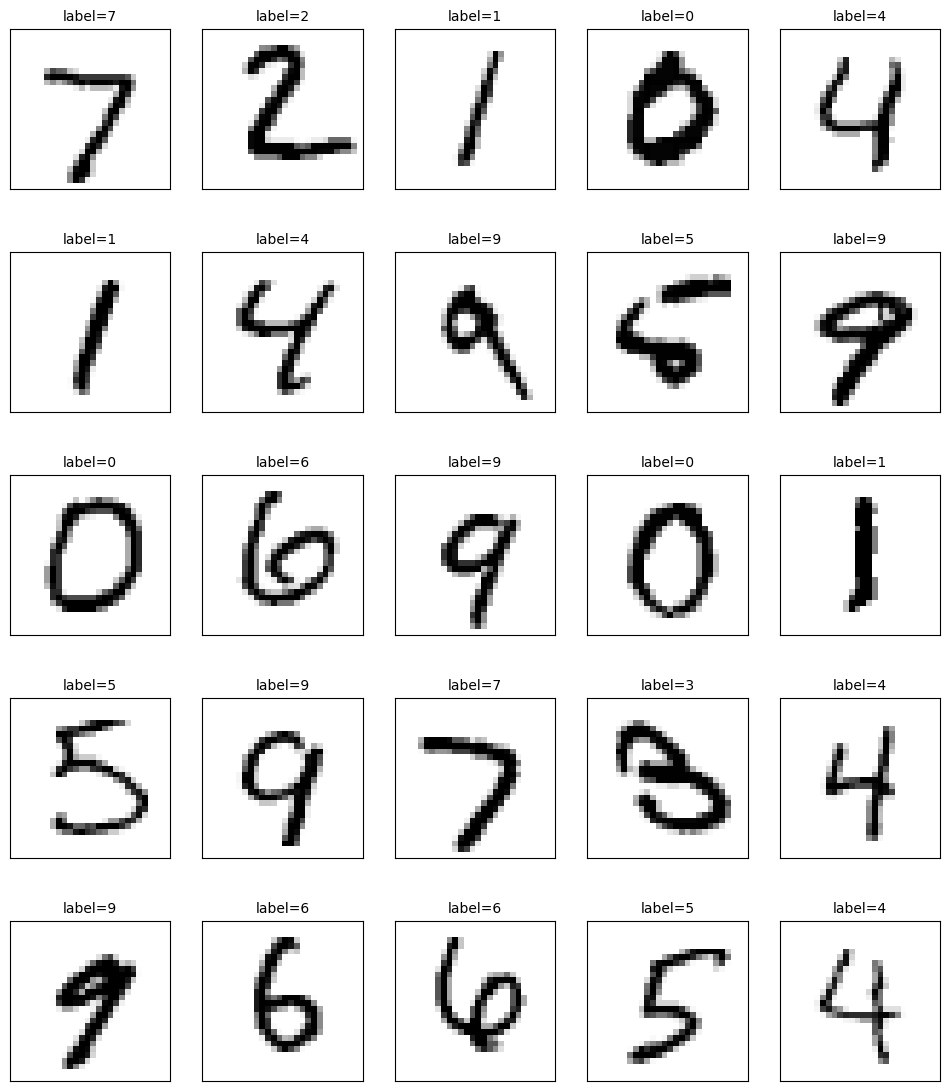

In [31]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images,labels,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25: num=25
    for i in range(0, num):
        ax=plt.subplot(5, 5, i+1)
        ax.imshow(images[idx], cmap='binary')
        title="label=" + str(labels[idx])
        ax.set_title(title, fontsize=10)
        ax.set_xticks([]);
        ax.set_yticks([]);
        idx += 1
    plt.show()

plot_images_labels_prediction(x_test_image, y_test_label, 0, 25)

